<center><h1>Machine Learning Model Evaluation & Benchmarking Methods</h1>
    <h2> Rebecca Hinrichs </h2>
    <h4> Data Mining </h4>
    <h6> 27 Sept 2022 </h6></center>

***

We would like to explore the publicly-available database 'Data11tumors.csv' for Cancer Classification based on Microarray Gene Expression and devise a Machine Learning Model trained to classify new data points with as near-perfect accuracy as we possibly can using hyperparameter optimization techniques. The data set we'll be using contains data collected from cancer patients. Using techniques built into Python's Pandas, NumPy, and Matplotlib libraries, we will examine this data set using techniques of Exploratory Data Analysis. We will then partition our data for training and testing, optimize the training data, and attempt to achieve as high accuracy as possible using SciKit-Learn's KNN ('k' Nearest Neighbors) and GaussianNB (Gaussian Naive-Bayes) libraries. Finally, we'll demonstrate our findings with visualizations from SciKit-Learn's YellowBrick Classifier visualizer, and we'll do this using a series of functions to process our data with each classifer, and discuss our results.

***

## *** Exploratory Data Analysis ***
To begin, we will wrangle the data provided in the data set in order to examine its contents. We will then optimize the data in order to prepare our model.

***

In [413]:
# Import libraries & dependencies
%matplotlib inline
# Data Analysis libraries
import numpy as np
import pandas as pd
# Machine Learning libraries: Data Prep
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
# Machine Learning libraries: Modeling
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
# Data Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
import scikitplot as skplt
# suppress version deprication warnings
import warnings
warnings.filterwarnings('ignore')

In [414]:
# Loading the Data
data = pd.read_csv('Data11tumors.csv')
print('\nOur data set contains', data.shape[0], 'rows and', data.shape[1], 'columns.')
print('\nGiven that we have so many columns, we\'ll print just the first 10 names.')
print('\nThe first 10 names of our', data.shape[1], 'variables (features) are:')
[print(i) for i in data.columns[0:10]]


Our data set contains 174 rows and 12534 columns.

Given that we have so many columns, we'll print just the first 10 names.

The first 10 names of our 12534 variables (features) are:
Classes
Gen1
Gen2
Gen3
Gen4
Gen5
Gen6
Gen7
Gen8
Gen9


[None, None, None, None, None, None, None, None, None, None]

It appears we have one unique variable at the beginning of our features list, `Classes`, and the rest appear that they may follow a pattern of identifiers `Gen(x)` where `(x)` is an incrementally increasing number starting at 1. Let's make sure that's the case and count the number of `Gen` rows we have in total. If our conjecture holds, we should have the total number of columns - 1 (for `Classes`) = `len(pd.unique(data.columns)) - 1` = $12533$ so that our last `Gen` name should be `Gen12533`. Another way we can check for this is by comparing all column names with the string 'Gen'.

In [415]:
print('\nThe name of the last variable in our data set is', data.columns[-1])
print('\nTherefore we have one column identifying', data.columns[0], 'and', \
      len(pd.unique(data.columns))-1 ,'individual genomic patterns (features).\n')
print('The following columns are not Gene-identifying features:')
[print(i) for i in data if i[0:3] != 'Gen']


The name of the last variable in our data set is Gen12533

Therefore we have one column identifying Classes and 12533 individual genomic patterns (features).

The following columns are not Gene-identifying features:
Classes


[None]

In [416]:
# Summarizing the Data
print('\nWe can get a snapshot of the first 5 rows of the data available using head().')
print('From this small sample we can estimate how each feature was recorded.')
data.head()


We can get a snapshot of the first 5 rows of the data available using head().
From this small sample we can estimate how each feature was recorded.


,Classes,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,...,Gen12524,Gen12525,Gen12526,Gen12527,Gen12528,Gen12529,Gen12530,Gen12531,Gen12532,Gen12533
0,7,153,228,32,30,-36,48,984,-19,537,...,100,30,83,28,57,106,128,5,74,-188
1,7,154,99,43,55,66,63,5051,-26,1001,...,27,43,90,30,82,485,896,-2,91,-78
2,7,84,85,19,28,-104,28,2387,-80,1131,...,-32,51,110,10,86,62,76,-47,92,-103
3,7,234,169,40,36,81,6,2657,-6,1214,...,43,52,82,12,135,60,69,22,89,-180
4,7,104,58,42,13,107,5,3562,18,1464,...,159,42,73,1,82,60,50,30,74,-198


We can see that the the Classes are represented by integers, and all of our 'Gen' features appear to be integers as well, and include both positive and negative numbers. We can't tell at this quick glance whether there are any $N/A$ or $0$ values in the dataset, so we'll test for each.

In [417]:
# Looking for missing (NaN) values
print('\nWe can find missing values by using .isna() and .sum() in conjunction on our Pandas dataframe.')
print('\nThe total number of cells containing missing (NaN) values in our data set is', data.isna().sum().sum(),'\n')
# Looking for zero values
print('The total number of cells containing zero values in our data set is', data.loc[data.values==0.0].shape[0],'\n')


We can find missing values by using .isna() and .sum() in conjunction on our Pandas dataframe.

The total number of cells containing missing (NaN) values in our data set is 0 

The total number of cells containing zero values in our data set is 8728 



Although there are no missing values among our thousands of variables, we have a large total number of $0$ values... $8728$ to be exact. <br>Which column has the largest number of zeroes? How many does it have?

In [418]:
# Locating the most zeroes
data_zeroes = (data==0).sum()
data_zeroes.loc[data_zeroes==max(data_zeroes)]
# another way to do this would have been:
# data_zeroes.nlargest(1)

Classes    27
dtype: int64

It looks as though the `Classes` column contains the majority of the zeroes. We saw earlier that this column is represented by an integer, so we can expect these $0$ values to be one of the Class labels. The column `Classes` only contains $27$ of the total $8728$ zeroes in the dataset, and that is the highest value of any column. To find where the rest of the zeroes are in our data, we'll look at all of the features containing at least 10 zeroes.

In [419]:
# Locating zero-valued data in the variables
print('\nThere are at least ten zero values located in the following columns:')
print(data_zeroes[data_zeroes>=10])
print('\nThis list contains', len(data_zeroes[data_zeroes>=10]), \
      'columns, and the second-largest column after \'Classes\' contains', data_zeroes.nlargest()[1], 'zeroes.\n')
print('This leaves us a remainder of', \
     data_zeroes.sum() - data_zeroes[data_zeroes>=10].sum(), 'zero values dispersed among the remaining variables.\n')


There are at least ten zero values located in the following columns:
Classes     27
Gen1355     10
Gen1389     11
Gen1609     14
Gen2008     10
Gen2605     10
Gen2783     10
Gen2949     12
Gen2951     10
Gen3562     11
Gen3753     10
Gen4014     16
Gen4437     10
Gen4636     10
Gen5046     10
Gen5508     11
Gen5997     10
Gen6346     11
Gen6438     15
Gen7106     13
Gen7675     11
Gen9277     11
Gen9377     14
Gen9554     10
Gen9686     10
Gen10442    13
Gen11759    11
dtype: int64

This list contains 27 columns, and the second-largest column after 'Classes' contains 16 zeroes.

This leaves us a remainder of 8407 zero values dispersed among the remaining variables.



$8407$ represents $8407/(12533 * 174) = zeroes/(variables * rows)$ which is less than $0.4\%$ of the total data set. Similarly, our list of $10+$ counts of zeroes contains only $27$ features, which is less than $1.6\%$ of our total features. This is not a large proportion of our data set and we can assume insignificant concern for faulty weights or values. To confirm, we'll assess the largest percentage of the feature containing the most zero values (`Gen4014` with $16$ zeroes) in terms of its total data points.

In [420]:
# Examining the largest zero
print('\nThe variable \'Gen4014\' contains', \
      ((data['Gen4014']==0).sum() / data['Gen4014'].count()) * 100, \
     '% percent of its data in terms of zero.\n')


The variable 'Gen4014' contains 9.195402298850574 % percent of its data in terms of zero.



In [421]:
# Comparing statistics
print('\nWe can also get a summarized statistics report of each feature using describe().')
print('From this summary we can witness the numerical differences between the variables.')
data.describe()


We can also get a summarized statistics report of each feature using describe().
From this summary we can witness the numerical differences between the variables.


,Classes,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,...,Gen12524,Gen12525,Gen12526,Gen12527,Gen12528,Gen12529,Gen12530,Gen12531,Gen12532,Gen12533
count,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,...,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000
mean,4.425287,218.413793,537.942529,71.965517,83.706897,-67.155172,-16.568966,644.988506,76.609195,1472.890805,...,-1.327586,93.120690,138.028736,2.839080,97.948276,62.850575,102.396552,12.913793,206.942529,-220.873563
std,3.245743,117.290761,268.926376,43.827156,122.828468,141.340339,62.832499,1092.470272,863.362875,650.125888,...,96.165089,45.964957,67.895485,44.568288,95.784336,80.848968,127.692587,27.441552,402.505214,217.480811
min,0.000000,-122.000000,30.000000,-24.000000,-80.000000,-900.000000,-206.000000,-551.000000,-205.000000,23.000000,...,-235.000000,12.000000,-26.000000,-146.000000,-349.000000,-184.000000,-75.000000,-56.000000,37.000000,-992.000000
25%,2.000000,148.750000,360.000000,44.000000,24.250000,-129.750000,-58.000000,-32.250000,-67.750000,1060.250000,...,-54.750000,59.250000,92.250000,-20.500000,46.000000,16.000000,20.500000,-4.000000,96.000000,-332.500000
50%,4.000000,210.500000,520.500000,65.000000,65.000000,-43.500000,-15.000000,146.000000,-35.500000,1427.500000,...,-5.500000,87.500000,131.500000,7.000000,113.000000,43.000000,73.500000,10.000000,142.000000,-208.500000
75%,7.000000,281.750000,706.750000,87.750000,111.000000,26.500000,23.000000,838.750000,-3.750000,1774.500000,...,41.000000,118.750000,169.500000,33.500000,155.500000,96.750000,145.000000,25.500000,210.500000,-142.000000
max,10.000000,616.000000,1419.000000,247.000000,1307.000000,264.000000,138.000000,5218.000000,10019.000000,4120.000000,...,452.000000,270.000000,414.000000,100.000000,480.000000,485.000000,896.000000,109.000000,4888.000000,1351.000000


We observe a sizeable disparity between our max and min values, and our mean values spread across all features.

In [422]:
print('\nThe maximum data point recorded is', data.values.max())
print('The minimum data point recorded is', data.values.min())
print('The average of all data points is', data.values.mean(),'\n')


The maximum data point recorded is 67796
The minimum data point recorded is -7346
The average of all data points is 296.40840179080715 



We're going to replace the `Classes` numerical labels with what their true labels represent, in order to curb any confusion moving forward. To do this, we're referencing the publication referenced in this report.

In [424]:
# Storing integer values representing Classes for functions later
Y = data['Classes'].values
# Replacing integer values representing Classes with String Reference Labels
data['Classes'] = data['Classes'].replace([0,1,2,3,4,5,6,7,8,9,10],
                        ['Ovary','Bladder/Ureter','Breast','Colorectal','Gastroesophagus',
                        'Kidney','Liver','Prostate','Pancreas','Lung Adeno','Lung Squamous'])
data.head()

,Classes,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,...,Gen12524,Gen12525,Gen12526,Gen12527,Gen12528,Gen12529,Gen12530,Gen12531,Gen12532,Gen12533
0,Prostate,153,228,32,30,-36,48,984,-19,537,...,100,30,83,28,57,106,128,5,74,-188
1,Prostate,154,99,43,55,66,63,5051,-26,1001,...,27,43,90,30,82,485,896,-2,91,-78
2,Prostate,84,85,19,28,-104,28,2387,-80,1131,...,-32,51,110,10,86,62,76,-47,92,-103
3,Prostate,234,169,40,36,81,6,2657,-6,1214,...,43,52,82,12,135,60,69,22,89,-180
4,Prostate,104,58,42,13,107,5,3562,18,1464,...,159,42,73,1,82,60,50,30,74,-198


In [425]:
# Determining evaluative factors
print('\nWe confirm that each record has been assigned a class using .count()', \
      data['Classes'].count(), 'which equals our dataset\'s number of rows', data.shape[0])
print('\nFinally, we can evaluate the distribution of each of the \'Classes\' feature using groupby().')
data_class_dist = data.groupby('Classes').size()
data_class_dist


We confirm that each record has been assigned a class using .count() 174 which equals our dataset's number of rows 174

Finally, we can evaluate the distribution of each of the 'Classes' feature using groupby().


Classes
Bladder/Ureter      8
Breast             26
Colorectal         23
Gastroesophagus    12
Kidney             11
Liver               7
Lung Adeno         14
Lung Squamous      14
Ovary              27
Pancreas            6
Prostate           26
dtype: int64

In [426]:
print('\nGiven these counts, we observe an uneven distribution among a total of', \
      len(data_class_dist), 'classes, from', \
      min(data_class_dist), 'to', \
      max(data_class_dist), 'records apiece.\n')


Given these counts, we observe an uneven distribution among a total of 11 classes, from 6 to 27 records apiece.



***

## *** Machine Learning ***
Now we're ready to begin fitting our model. We'll begin by defining our data and labels to teach our model for classification.

#### *** Preparing the Data for Modeling ***

In [427]:
# Separate class labels from features and define as two data sets for classification modeling
data_classes = data['Classes']
data = data.drop('Classes', axis=1)
data_feat = pd.DataFrame(data, columns=[x for x in data.columns])
data_feat.shape

(174, 12533)

In [428]:
# Define dependent (Y) and independent (X) variables for our model F where F(X)=Y
print('\nWe\'ll start by assigning our X and Y values to begin modeling our data.\n')
X = data.copy()
y = data_classes.values

print(f'`X` contains all of the data values as a {X.shape[0]} by {X.shape[1]} data frame.')
print(f'`Y` contains the class labels for each record as a {y.shape[0]} list of values.')


We'll start by assigning our X and Y values to begin modeling our data.

`X` contains all of the data values as a 174 by 12533 data frame.
`Y` contains the class labels for each record as a 174 list of values.


***

##### Discarding Collinearities
Collinear variables are those which present a highly collinear relationships, exposed by means of a correlation matrix. Highly correlated variables present inflation to our variance because interdependency of variables pull weight from the coefficients of other independent variables in relationship to the output. In other words, in order to define as succint a formula as possible (the linear equation our model will formulate), we must make sure every variable as input is completely independent. We will implement a threshold of $90\%$ collinearity required in order to discard any particular variable as redundant.

In [429]:
# Pre-processing variables to check for collinearity
var_threshold = VarianceThreshold(threshold = 0)
var_threshold.fit(X)
X_cols = X.columns[var_threshold.get_support()]
X = var_threshold.transform(X)
X = pd.DataFrame(X, columns = X_cols)
print('\nConfirming our original data frame has passed all checks, retaining its shape:', X.shape)


Confirming our original data frame has passed all checks, retaining its shape: (174, 12533)


In [430]:
# Define threshold of collinearity to be at least 90-percent
threshold = 0.9

# Detect correlation between variables using correlation matrix
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
upper.head()

,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,Gen10,...,Gen12524,Gen12525,Gen12526,Gen12527,Gen12528,Gen12529,Gen12530,Gen12531,Gen12532,Gen12533
Gen1,NaN,0.335859,0.241444,0.123989,0.301285,0.066934,0.176200,0.030922,0.001206,0.399932,...,0.174236,0.412143,0.193058,0.152631,0.338063,0.234791,0.127079,0.220235,0.000891,0.330172
Gen2,NaN,NaN,0.244218,0.117454,0.229678,0.249078,0.304167,0.024746,0.257993,0.276137,...,0.186326,0.415163,0.129953,0.053406,0.115217,0.325180,0.192264,0.224995,0.055826,0.334725
Gen3,NaN,NaN,NaN,0.012979,0.150880,0.142334,0.092944,0.032574,0.247088,0.200968,...,0.345071,0.455954,0.335723,0.186256,0.184106,0.143218,0.264731,0.224216,0.096255,0.139686
Gen4,NaN,NaN,NaN,NaN,0.005021,0.173236,0.016677,0.014081,0.211205,0.111385,...,0.103634,0.016873,0.184160,0.089724,0.065803,0.077945,0.132470,0.015869,0.011146,0.474120
Gen5,NaN,NaN,NaN,NaN,NaN,0.116745,0.290613,0.025399,0.061903,0.237442,...,0.135739,0.317394,0.210854,0.071881,0.195893,0.180772,0.135209,0.196089,0.031366,0.173755


In [431]:
# Select columns which have correlations above specified threshold
cols_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('\nThere are %d collinear columns to remove.\n' % (len(cols_to_drop)))


There are 553 collinear columns to remove.



In [432]:
# Remove collinear columns from dataset
X = X.drop(cols_to_drop, axis=1)
print(X.shape)

(174, 11980)


We have detected and removed from our dataset a total of $553$ columns which have a high instance of collinearity, as we specified to be anything more than $90\%$ of positive correlation. After removing these variables, we can proceed to train our model with our optimized data set.

In [433]:
# Making optimized data copies for passing through different training sets later in this report
X_copy = X.copy()
y_copy = y.copy()

***

#### *** Building the Model ***
Now we can start building the model. First we'll identify which data will be used for the model and which will remain untouched for testing. We'll train the model using $75\%$ of the data and test the remaining $25\%$ using our model in order to determine its accuracy. These are the default parameters when no parameter optimization is used. We'll keep our parameters basic in this step in order to compare our optimized models.

In [434]:
# The model's framework is, by default, made up of 25% of the data set for testing, 75% for training
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [435]:
# Summary of Model Parameters
print('\nWe will train our model to predict the Class to which each feature belongs based on its data.')
print()
print('Our training model has', X_train.shape[0], 'rows x', X_train.shape[1], 'columns ' \
     'representing data points collected.\n' \
      'These make a total of', X_train.shape[0]*X_train.shape[1],'independent (x) inputs to our model,\n' \
      'delivering', y_train.shape[0], 'dependent (y) linear outputs from some function F(x)=y.')
print('Our training model hosts',(X_train.shape[0]/data.shape[0]*100), '% of the data.')
print()
print('Our testing model has', X_test.shape[0], 'rows x', X_test.shape[1], 'columns ' \
     'representing data points collected.\n' \
      'These make a total of', X_test.shape[0]*X_test.shape[1],'independent (x) inputs to our model,\n' \
      'delivering', y_test.shape[0], 'dependent (y) linear outputs from proposed function F(x)=y.')
print('Our testing model hosts',(X_test.shape[0]/data.shape[0]*100), '% of the data.')
print()
print('The testing data will be used to judge accuracy of our trained model.\n')


We will train our model to predict the Class to which each feature belongs based on its data.

Our training model has 130 rows x 11980 columns representing data points collected.
These make a total of 1557400 independent (x) inputs to our model,
delivering 130 dependent (y) linear outputs from some function F(x)=y.
Our training model hosts 74.71264367816092 % of the data.

Our testing model has 44 rows x 11980 columns representing data points collected.
These make a total of 527120 independent (x) inputs to our model,
delivering 44 dependent (y) linear outputs from proposed function F(x)=y.
Our testing model hosts 25.287356321839084 % of the data.

The testing data will be used to judge accuracy of our trained model.



###### Scaling the Data
Due to the large disparity of the max() and min() values and the large gaps between our averages, we could benefit by scaling our data into a narrower interval. We'll scale the data in our training set in order to achieve as high precision as possible.

In [436]:
# Before testing, we'll scale our (x) training inputs in order to ensure uniform evaluation
X_cols = list(X.columns)
scaler = StandardScaler().fit(X)
scaled_data = scaler.transform(X)
X = pd.DataFrame(scaled_data, columns=X_cols)

# We can use .head() to confirm the scaling was effective
X.head()

,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,Gen10,...,Gen12524,Gen12525,Gen12526,Gen12527,Gen12528,Gen12529,Gen12530,Gen12531,Gen12532,Gen12533
0,-0.559316,-1.155844,-0.914521,-0.438513,0.221063,1.030602,0.311212,-0.111060,-1.443708,-0.380667,...,1.056725,-1.377198,-0.812831,0.566177,-0.428739,0.535244,0.201087,-0.289220,-0.331241,0.151592
1,-0.550765,-1.636914,-0.662811,-0.234390,0.944808,1.270021,4.044712,-0.119191,-0.727940,-0.554801,...,0.295423,-1.093558,-0.709434,0.611181,-0.166982,5.236526,6.232890,-0.545043,-0.288884,0.658844
2,-1.149295,-1.689123,-1.211997,-0.454843,-0.261434,0.711377,1.599164,-0.181918,-0.527402,-0.206533,...,-0.319876,-0.919010,-0.414013,0.161137,-0.125101,-0.010551,-0.207316,-2.189625,-0.286392,0.543559
3,0.133269,-1.375868,-0.731459,-0.389524,1.051241,0.360229,1.847023,-0.095959,-0.399366,-0.362979,...,0.462283,-0.897191,-0.827602,0.206141,0.387941,-0.035360,-0.262293,0.332067,-0.293867,0.188483
4,-0.978287,-1.789812,-0.685694,-0.577317,1.235725,0.344268,2.677812,-0.068081,-0.013715,-0.533454,...,1.672024,-1.115376,-0.960541,-0.041383,-0.166982,-0.035360,-0.411518,0.624437,-0.331241,0.105479


In [437]:
print('Our data is now optimized to submit to our models, ' \
      'and its dimensional shape is', X.shape)
print('Our list of unique features is', len(X.columns))
print('And our list of class data for clustering is', y.shape)

Our data is now optimized to submit to our models, and its dimensional shape is (174, 11980)
Our list of unique features is 11980
And our list of class data for clustering is (174,)


***

# Refreshing Data
We're creating a code block which we'll repeat implementing between our models. We'll also show a quicker model at the end using functions, but utilizing this method allows us to annotate our report. You'll notice our variables are set to copy the pre-fitted 'x' and 'y' variables which have been optimized but not yet fitted to any particular model. The model splitting formula is here mostly for reference, as this will change depending upon whether we'll be utilizing hyperparameter optimization. After the data is fitted to the model, we'll scale the training data for precision. This is an iterable process.

In [438]:
# Our independent variables are our data points; dependent variables are our labels (Classes)
X = X_copy.copy()
y = y_copy.copy()

# The model's framework is, by default, made up of 25% of the data set for testing, 75% for training
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Before testing, we'll scale our (x) training inputs in order to ensure uniform evaluation
X_cols = list(X.columns)
scaler = StandardScaler().fit(X)
scaled_data = scaler.transform(X)
X = pd.DataFrame(scaled_data, columns=X_cols)

***

# *** Classifying the Data ***

We'll now apply Machine Learning techniques in order to build a model of classification for our data set. We'll utilize two of Python's Machine Learning libraries- KNN (or 'k' Nearest Neighbor) and Gaussian Naive Bayes- and we'll assess whether parameter optimization may help us improve the performance of our model or cause overfitting of the data.

***

### *** 'k' Nearest Neighbors ***
We'll implement a KNN Classification model using SciKit-Learn's default parameters on our optimized dataset.

In [439]:
# First we'll use the default values from within the KNN library where n_neighbors = 5
knn = KNeighborsClassifier().fit(X_train, y_train)
predictions = knn.predict(X_test)
y_pred = knn.predict(X_test)

Now we are ready to implement our trained model to make a set of predictions on our test data.

In [440]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
# Classification Report
print(classification_report(y_test, y_pred))
# Accuracy report
print('\nAccuracy is', (100*accuracy_score(y_test,y_pred)), '% percent.')

[[2 0 0 0 0 0 0 0 1 0 0]
 [0 6 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0]
 [0 0 2 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 9]]
                 precision    recall  f1-score   support

 Bladder/Ureter       1.00      0.67      0.80         3
         Breast       1.00      1.00      1.00         6
     Colorectal       0.50      1.00      0.67         3
Gastroesophagus       0.00      0.00      0.00         2
         Kidney       0.67      1.00      0.80         2
          Liver       0.00      0.00      0.00         1
     Lung Adeno       1.00      1.00      1.00         4
  Lung Squamous       0.67      1.00      0.80         2
          Ovary       0.70      0.78      0.74         9
       Pancreas       1.00      0.50      0.67         2
       Prostate       1.00      0.90      0.95        10

       accuracy                       

Our results show that our KNN algorithm was able to classify all $44$ records in the test set with $77\%$ accuracy, which is not optimal. We'll attempt to optimize our model using parameter specifications.

***

#### *** Optimizing Parameters: 'k' Nearest Neighbors ***
We'll implement a Manhattan distance heuristic to fit the training data. We'll also implement a loop to determine which is the best 'k' value to pass to KNN's `n_neighbors` parameter.

In [441]:
# REFRESHING THE DATA
# Our independent variables are our data points; dependent variables are our labels (Classes)
X = X_copy.copy()
y = y_copy.copy()

# The model's framework is made up of 20% of the data set for testing, 80% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,     # test size of 20%
                                                    random_state=101,  # random state = 101
                                                    stratify=y)        # distribute shuffling

# Before testing, we'll scale our (x) training inputs in order to ensure uniform evaluation
X_cols = list(X.columns)
scaler = StandardScaler().fit(X)
scaled_data = scaler.transform(X)
X = pd.DataFrame(scaled_data, columns=X_cols)

In [442]:
# Testing set (KNN model object)
knn = KNeighborsClassifier(n_neighbors=11,      # number of predicted neighbors / classifiers
                           weights='distance',  # density is determined by distance btwn points
                           metric='manhattan',  # manhattan distance
                          algorithm='auto',     # allow model to decide best algorithm from .fit
                          )
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

In [443]:
# Confusion matrix and classification report
print(confusion_matrix(y_test,predictions))

# Prediction values using Optimized KNN model and X test
print(classification_report(y_test,predictions))

# Accuracy report
print('\nAccuracy is', (100*accuracy_score(predictions,y_test)), '% percent.')

[[1 0 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 2 1 0 0 0]
 [0 0 1 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 5]]
                 precision    recall  f1-score   support

 Bladder/Ureter       1.00      0.50      0.67         2
         Breast       0.83      1.00      0.91         5
     Colorectal       0.62      1.00      0.77         5
Gastroesophagus       1.00      0.50      0.67         2
         Kidney       1.00      1.00      1.00         2
          Liver       0.00      0.00      0.00         1
     Lung Adeno       0.60      1.00      0.75         3
  Lung Squamous       1.00      0.33      0.50         3
          Ovary       1.00      0.83      0.91         6
       Pancreas       1.00      1.00      1.00         1
       Prostate       1.00      1.00      1.00         5

       accuracy                       

We see that optimizing our parameters has been helpful! We now have a better accuracy rating using more samples. Let's see how we can optimize this further using error reduction techniques.

Text(0, 0.5, 'Mean Error')

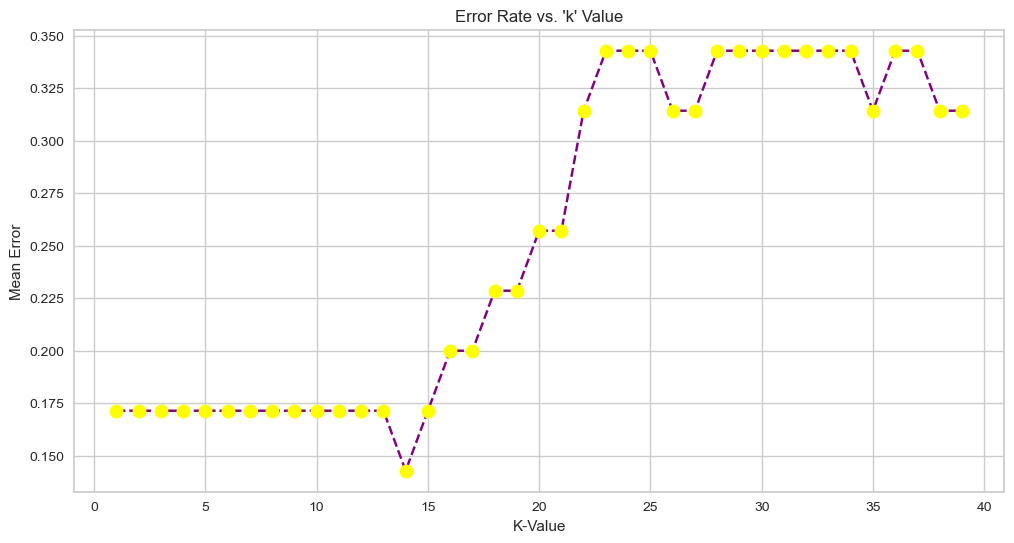

In [444]:
# Now we'll train various KNN models using different k values and track the error rate for each
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i,      # number of predicted neighbors / classifiers
                           weights='distance',  # density is determined by distance btwn points
                           metric='manhattan',  # manhattan distance
                          algorithm='auto',     # allow model to decide best algorithm from .fit
                          )
    knn.fit(X_train, y_train)
    predictions_i = knn.predict(X_test)
    error_rate.append(np.mean(predictions_i != y_test))
# Using this list of values, we can determine the best k-value
# By plotting the Error Rate according to each k-Value Tested
plt.figure(figsize = (12,6))
plt.plot(range(1,40), error_rate, color='purple', linestyle='dashed', marker='o', 
         markerfacecolor='yellow', markersize=10)
plt.title('Error Rate vs. \'k\' Value')
plt.xlabel('K-Value')
plt.ylabel('Mean Error')

In [445]:
# Now we'll find the k-values where the minimum error rate occurs & compare the outputs
find_min = pd.DataFrame(X_test, error_rate)
mins = np.where(error_rate == min(error_rate))
poss_k = list(mins[0])
print('\nThis algorithm says', poss_k, 'are the best k-Values.\n')


This algorithm says [13] are the best k-Values.



In [446]:
# Finally, we'll compare the Classification Report & Confusion Matrix for each 'k' proposal
for i in poss_k:
    if i != 0:  # We cannot have no neighbors
        # Determine best k-value
        knn = KNeighborsClassifier(n_neighbors=i,      # number of predicted neighbors / classifiers
                                   weights='distance',  # density is determined by distance btwn points
                                   metric='manhattan',  # manhattan distance
                                  algorithm='auto',     # allow model to decide best algorithm from .fit
                                  )
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_test)
        print('\n<<--------------------------------------------------------->>')
        print(f'\tFor k = {i} we have the following report:\n')
        # Confusion matrix
        print(confusion_matrix(y_test,predictions))
        print()
        # Classification report
        print(classification_report(y_test,predictions))
        # Accuracy report
        print('\nAccuracy is', (100*accuracy_score(predictions,y_test)), '% percent.')


<<--------------------------------------------------------->>
	For k = 13 we have the following report:

[[1 0 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 2 1 0 0 0]
 [0 0 1 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 5]]

                 precision    recall  f1-score   support

 Bladder/Ureter       1.00      0.50      0.67         2
         Breast       0.83      1.00      0.91         5
     Colorectal       0.62      1.00      0.77         5
Gastroesophagus       1.00      0.50      0.67         2
         Kidney       1.00      1.00      1.00         2
          Liver       0.00      0.00      0.00         1
     Lung Adeno       0.60      1.00      0.75         3
  Lung Squamous       1.00      0.33      0.50         3
          Ovary       1.00      0.83      0.91         6
       Pancreas       1.00      1.00      1.00

From these results, it appears our optimal 'k' value is $k=4$ or $k=6$ with $81\%$ accuracy.

***

### *** Gaussian Naive-Bayes ***
We'll implement a Gaussian Naive-Bayes Classification model using SciKit-Learn's default parameters on our optimized dataset.

In [447]:
# REFRESH THE DATA
# Our independent variables are our data points; dependent variables are our labels (Classes)
X = X_copy.copy()
y = y_copy.copy()

# The model's framework is, by default, made up of 25% of the data set for testing, 75% for training
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Before testing, we'll scale our (x) training inputs in order to ensure uniform evaluation
X_cols = list(X.columns)
scaler = StandardScaler().fit(X)
scaled_data = scaler.transform(X)
X = pd.DataFrame(scaled_data, columns=X_cols)

In [448]:
# This time we'll fit our model using the Naive-Bayes Classifier algorithm
classifier = GaussianNB(var_smoothing=2e-9)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Accuracy report
print('\nAccuracy is', (100*accuracy_score(y_pred,y_test)), '% percent.')

                 precision    recall  f1-score   support

 Bladder/Ureter       1.00      1.00      1.00         1
         Breast       0.67      1.00      0.80         6
     Colorectal       0.57      1.00      0.73         4
Gastroesophagus       1.00      0.20      0.33         5
         Kidney       1.00      1.00      1.00         2
          Liver       1.00      0.50      0.67         2
     Lung Adeno       0.50      0.67      0.57         3
  Lung Squamous       1.00      0.60      0.75         5
          Ovary       1.00      1.00      1.00         9
       Prostate       1.00      1.00      1.00         7

       accuracy                           0.82        44
      macro avg       0.87      0.80      0.78        44
   weighted avg       0.88      0.82      0.80        44

[[1 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 3 1 0 0 1 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 2 0 0 0]
 [0 1 0 0 0 0 1 3 0 0]
 [0 0 0 0 0 0 0

The Gaussian Naive-Bayes model renders better results than our Optimized KNN model. It gives us $91\%$ accuracy and higher weighted average proportions.

#### *** Optimizing Parameters: Gaussian Naive-Bayes ***

In [449]:
# REFRESH THE DATA
# Our independent variables are our data points; dependent variables are our labels (Classes)
X = X_copy.copy()
y = y_copy.copy()

# The model's framework is made up of 20% of the data set for testing, 80% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,     # test size of 20%
                                                    random_state=101,  # random state = 101
                                                    stratify=y)        # distribute shuffling

# Before testing, we'll scale our (x) training inputs in order to ensure uniform evaluation
X_cols = list(X.columns)
scaler = StandardScaler().fit(X)
scaled_data = scaler.transform(X)
X = pd.DataFrame(scaled_data, columns=X_cols)

In [450]:
# This time we'll fit our model using the Naive-Bayes Classifier algorithm
GNB = GaussianNB(                      # prior classes = 11 but it will not accept this
                        var_smoothing=1e-9)   # fine-tuning of variance

GNB.fit(X_train, y_train)

y_pred = GNB.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Accuracy report
print('\nAccuracy is', (100*accuracy_score(y_test,y_pred)), '% percent.')

                 precision    recall  f1-score   support

 Bladder/Ureter       1.00      0.50      0.67         2
         Breast       0.56      1.00      0.71         5
     Colorectal       1.00      1.00      1.00         5
Gastroesophagus       1.00      1.00      1.00         2
         Kidney       1.00      1.00      1.00         2
          Liver       0.00      0.00      0.00         1
     Lung Adeno       1.00      0.67      0.80         3
  Lung Squamous       0.75      1.00      0.86         3
          Ovary       1.00      0.67      0.80         6
       Pancreas       1.00      1.00      1.00         1
       Prostate       1.00      1.00      1.00         5

       accuracy                           0.86        35
      macro avg       0.85      0.80      0.80        35
   weighted avg       0.89      0.86      0.85        35

[[1 1 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0

Finally, we will attempt to reduce our errors by optimizing our parameters. We can optimize our Gaussian Naive-Bayes model using Grid Search. Like our algorithm to find the best $k$ value above for our KNN algorithm, the GridSearchCV package allows us to find the best var-smoothing and number of cross-validation parameters to optimize our model without overfitting it, giving our best hopes of accuracy.

In [451]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), 
                            param_grid=param_grid_nb, 
                            verbose=1, 
                            cv=5, 
                            n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

# Fitting 5 folds
GaussianNB(priors=None, var_smoothing=1.0)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
GaussianNB(var_smoothing=0.0001519911082952933)


GaussianNB(var_smoothing=1.0)

In [452]:
y_pred = nbModel_grid.predict(X_test)
# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy report
print('\nAccuracy is', (100*accuracy_score(y_test,y_pred)), '% percent.')

                 precision    recall  f1-score   support

 Bladder/Ureter       1.00      1.00      1.00         2
         Breast       0.83      1.00      0.91         5
     Colorectal       1.00      1.00      1.00         5
Gastroesophagus       1.00      1.00      1.00         2
         Kidney       1.00      1.00      1.00         2
          Liver       0.00      0.00      0.00         1
     Lung Adeno       1.00      0.67      0.80         3
  Lung Squamous       0.75      1.00      0.86         3
          Ovary       1.00      1.00      1.00         6
       Pancreas       1.00      1.00      1.00         1
       Prostate       1.00      1.00      1.00         5

       accuracy                           0.94        35
      macro avg       0.87      0.88      0.87        35
   weighted avg       0.93      0.94      0.93        35

[[2 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0

Our Gaussian Naive-Bayes model was improved by optimizing its parameters using the GridSearchCV library from SciKit-Learn.

***

## *** Conclusion ***
We explored various techniques of training and optimizing a Machine Learning model to classify data using the Data 11 Tumors data set. We found our best results for this particular data set to be from the Gaussian Naive-Bayes model, which we improved using Grid Search parametrization, ultimately giving us $93\%$ accuracy.

***

We can show the basic models' comparative accuracy using Seaborn.

KNeighborsClassifier
****Results****
Accuracy: 77.1429%
GaussianNB
****Results****
Accuracy: 85.7143%


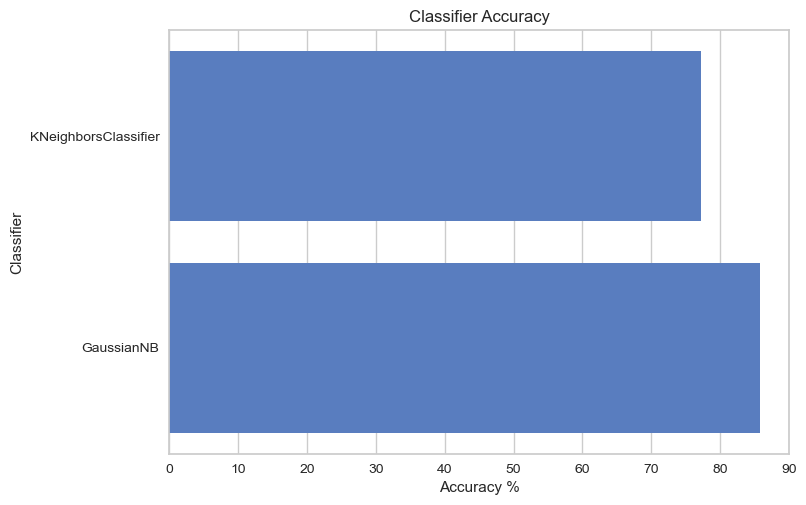

In [453]:
classifiers = [
    KNeighborsClassifier(),
    GaussianNB()
]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)
 
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    log_entry = pd.DataFrame([[name, acc*100, 11]], columns=log_cols)
    log = log.append(log_entry)
    
    print("="*30)
    
# Plot all 4 models's accuracy counts to compare using Seaborn
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

***

# Prof's Approach!
Finally, using these stellar functions created by Dr. Guillen-Rondon, we can do a quick side-by-side analysis visualizing correlation, precision and accuracy results between both classification models. You'll notice a confirmation of our above results.

In [454]:
# libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

#Visualizers
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import matplotlib.pyplot as plt

#Metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef
#Classifiers
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

In [455]:
# Our independent variables are our data points; dependent variables are our labels (Classes)
X = X_copy.copy()
y = Y.copy()

# The model's framework is made up of 20% of the data set for testing, 80% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,     # test size of 20%
                                                    random_state=101,  # random state = 101
                                                    stratify=y)        # distribute shuffling

# Before testing, we'll scale our (x) training inputs in order to ensure uniform evaluation
X_cols = list(X.columns)
scaler = StandardScaler().fit(X)
scaled_data = scaler.transform(X)
X = pd.DataFrame(scaled_data, columns=X_cols)

In [456]:
# select classifiers 
classifiers=[
KNeighborsClassifier(),
GaussianNB()]
# Define other variables for functions
classes = [0,1,2,3,4,5,6,7,8,9,10]

In [457]:
# Write functions for class-centric metrics
# Classification report
def CR_viz():
    def Class_report(model,classes):
        visualizer = ClassificationReport(model, classes=classes, support=True)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        return visualizer.poof()
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        Class_report(name,classes)

#Class Prediction Error
def CPE_viz():    
    def CPE(model,classes):
        visualizer = ClassPredictionError(model, classes=classes)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        CPE(name,classes)
        
#Confusion matrix
def CM_viz():    
    def CM(model,classes):
        visualizer = ConfusionMatrix(model, classes=classes,percent=True)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        CM(name,classes)
        
#ROC-AUC
def ROC_viz():    
    def ROC(model,classes):
        visualizer = ROCAUC(model, classes=classes)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        ROC(name,classes)

#Precision Recall Curve
def PRC_viz():  
    def PRC(model,classes):
        visualizer = PrecisionRecallCurve(model,classes=classes, per_class=True, iso_f1_curves=False,
    fill_area=False, micro=False)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        PRC(name,classes)
        
# Write function for aggregate metrics
def classifier_metrics():    
    def metrics(model):
        #     model=model_name()
        model.fit(X_train, y_train)  # Fit the visualizer and the model
        y_pred = model.predict(X_test)
        try: 
            y_prob = model.predict_proba(X_test)
            log_metric = log_loss(y_test,y_prob)
        except:
            y_prob = "Not probablistic"
            log_metric = 0
        else:
            y_pred = model.predict(X_test)
        c_k_s=cohen_kappa_score(y_test,y_pred)
        zero_met=zero_one_loss(y_test,y_pred)
        hl=hamming_loss(y_test,y_pred)
        mc=matthews_corrcoef(y_test,y_pred)
        print('cohen_kappa_score: {0:.3f}'.format(c_k_s))
        print('log_loss: {0:.3f}'.format(log_metric))
        print('zero_one_loss: {0:.3f}'.format(zero_met))
        print('hemming_loss: {0:.3f}'.format(hl))
        print('matthews_corrcoef: {0:.3f}'.format(mc))
    for name in classifiers:
        print (str(name))
        metrics(name)
        print()
        print ("------------------------------------------------------")

In [458]:
#Deploy aggregate metrics  
classifier_metrics()

KNeighborsClassifier()
cohen_kappa_score: 0.935
log_loss: 0.264
zero_one_loss: 0.057
hemming_loss: 0.057
matthews_corrcoef: 0.938

------------------------------------------------------
GaussianNB()
cohen_kappa_score: 0.870
log_loss: 3.947
zero_one_loss: 0.114
hemming_loss: 0.114
matthews_corrcoef: 0.876

------------------------------------------------------


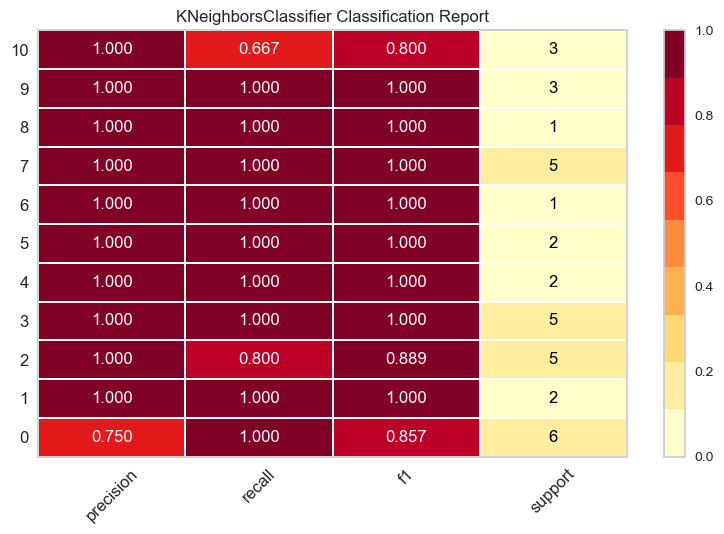

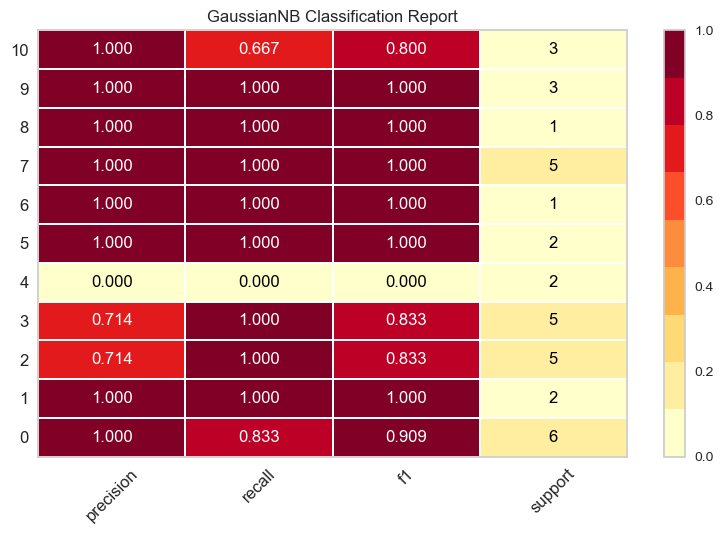

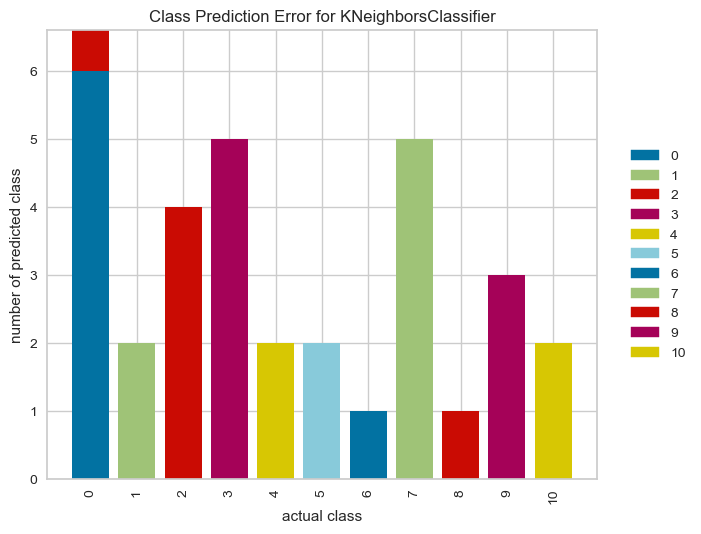

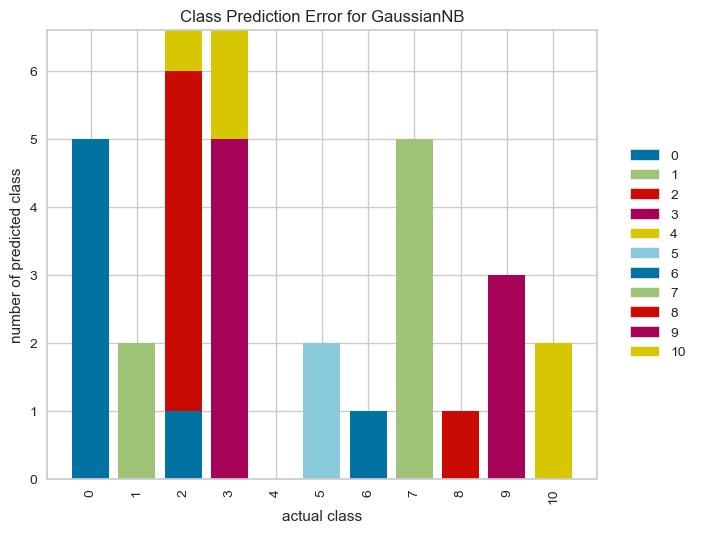

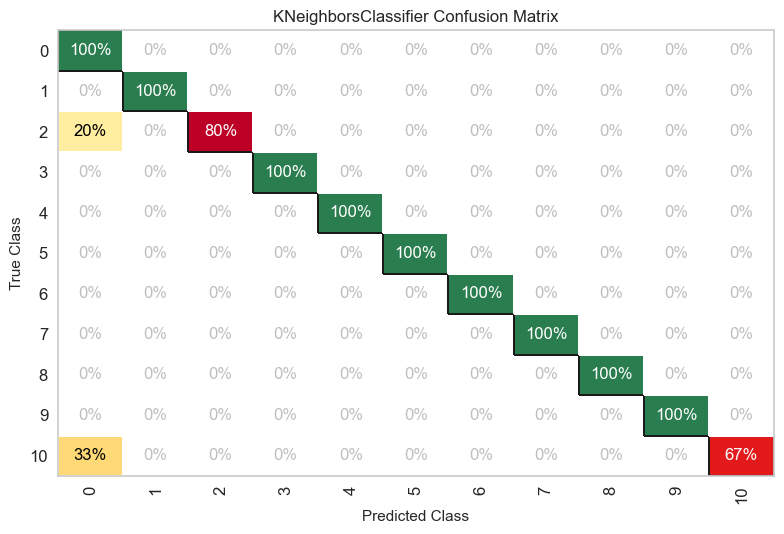

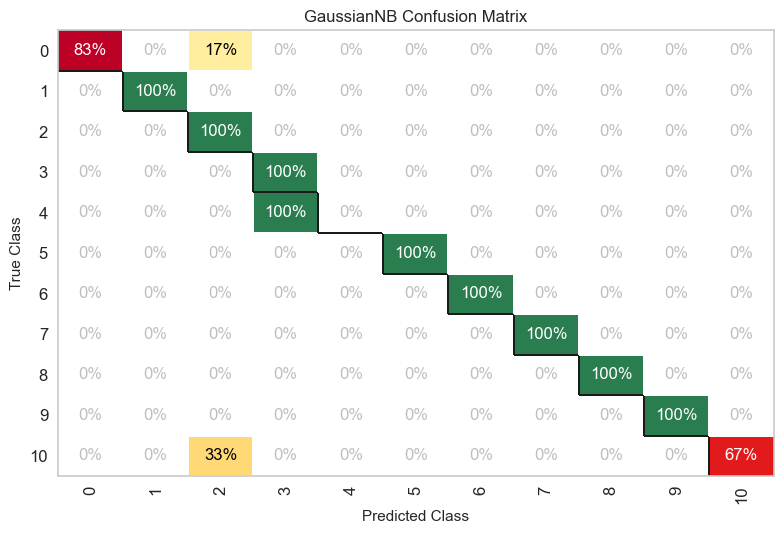

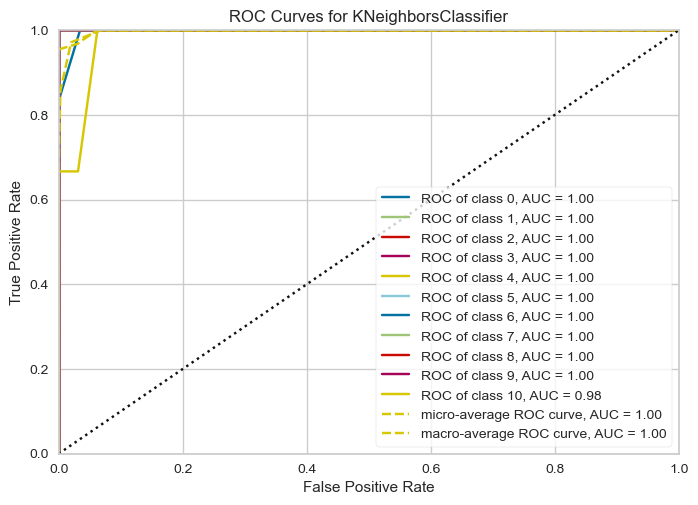

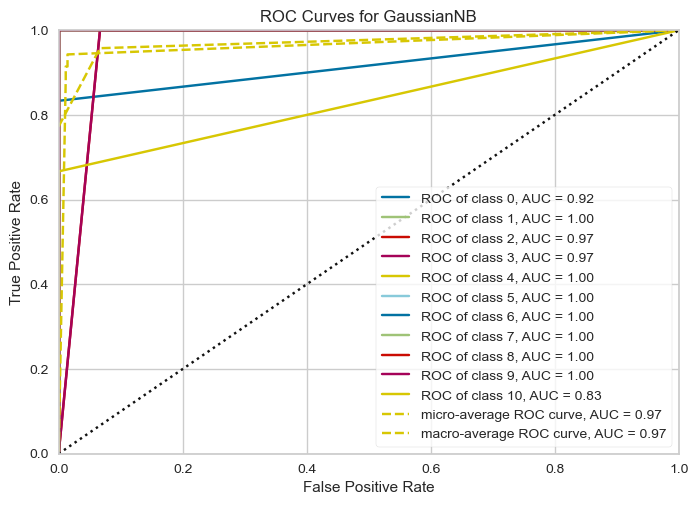

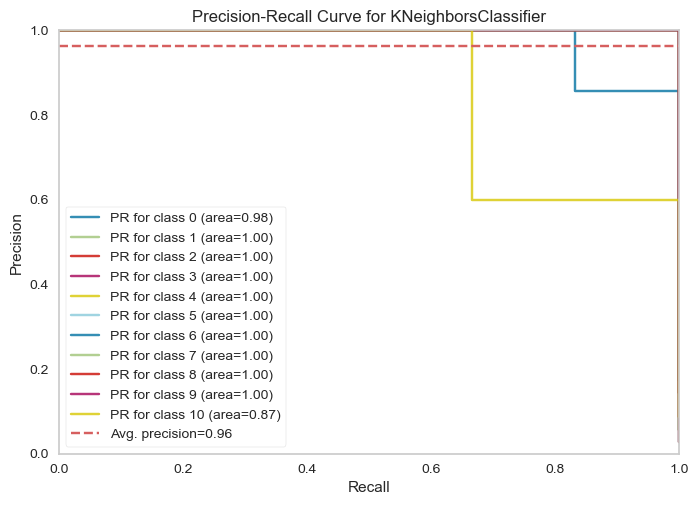

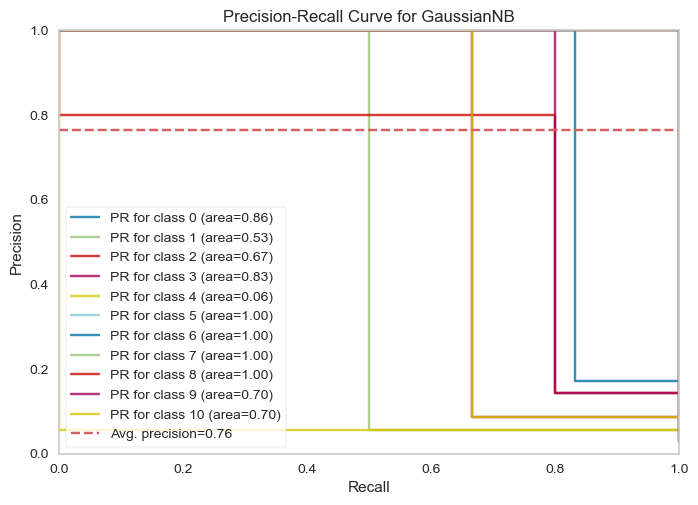

In [459]:
#deploy visualization
visualization =[CR_viz(),CPE_viz(),CM_viz(),ROC_viz(),PRC_viz()]

***

# Sources

Guillen-Rondon, Pablo, and Jerry Ebalunode. "Cancer Classification Based on Microarray Gene Expression Data Using Deep Learning." <i>2016 International Conference on Computational Science and Computational Intelligence</i>.

***